## Load libraries and data

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

In [3]:
path = 'AB_Test_Results.csv'
df = pd.read_csv(path)

df = df.rename(str.lower, axis='columns')

## EDA

In [4]:
df.head()

,user_id,variant_name,revenue
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [5]:
df.describe()

,user_id,revenue
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


The first EDA conclusions are as follows:
- As we can see from EDA report there are 17,8% duplicated rows. This is a lot and we will look closer at that in next steps.
- Also there are 63,2% distinct user_ids. That may be due to multiple sessions in data. We will aggregate it.
- Variant names are equally distributed. That's okay.
- Revenue column is skewed to the right. There might be an outlier around 200 USD.

In [7]:
# check if users have more than one variant group.
users_variants = df.groupby('user_id')['variant_name'].nunique()
multiple_variant_users = users_variants[users_variants == 2].index
multiple_variant_users.nunique() / df['user_id'].nunique()

0.24367488931056294

Almost 1/4 of users have more than one variant_name. Let's assume this has been given incorrect variant_name. They won't be included in further analysis.

<AxesSubplot: xlabel='revenue', ylabel='variant_name'>

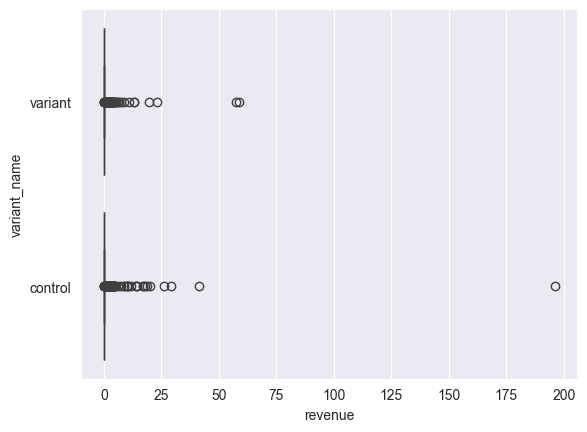

In [8]:
# Let's take a look at box-plot of revenue
sns.boxplot(data = df, x = 'revenue', y = 'variant_name')



The control group has one big outlier around 200 USD. This value can disturb the data, so it will be filtered out.

## Data clearing

In [9]:
# get rid of users with more than one variant name
df = df[~df['user_id'].isin(multiple_variant_users)]

# get rid of duplicates
df = df.drop_duplicates(keep = 'last')

# let's assume that user can have multiple sessions and make transaction in all of them. This user is converted so we want to keep all of his revenue
df = df.groupby(['user_id', 'variant_name'], as_index = False).sum('revenue')

# Filter out an outlier (around 200 USD value)
df = df[df['revenue'] <= 175]

<AxesSubplot: xlabel='revenue', ylabel='variant_name'>

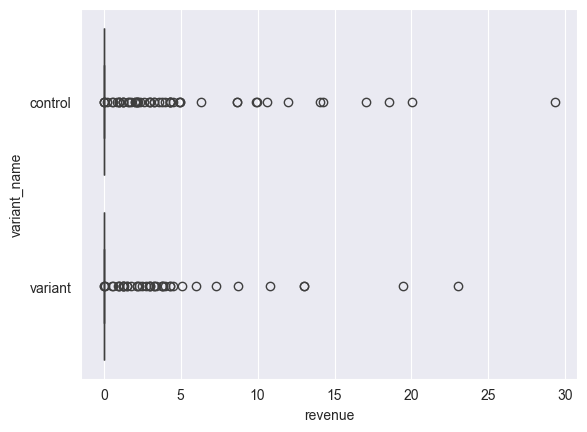

In [10]:
# Let's plot the distribution
sns.boxplot(data = df, x = 'revenue', y = 'variant_name')

Boxplot seems to be significantly better. Still there are some high revenue users but it's okay for analysis.
There are many non paying users with 0$ revenue. Let's check the paying users revenue.

In [11]:
# keep only paying users
revenue_df = df[df['revenue'] != 0]

In [12]:
# check descriptive statistics
revenue_df[['revenue','variant_name']].groupby(['variant_name']).describe()

revenue                                                     
               count      mean       std   min     25%   50%   75%    max
variant_name                                                             
control         53.0  5.180189  5.942771  0.02  1.5600  2.99  4.98  29.32
variant         42.0  4.269524  4.962253  0.02  1.2625  2.97  4.27  23.04

<AxesSubplot: xlabel='revenue', ylabel='variant_name'>

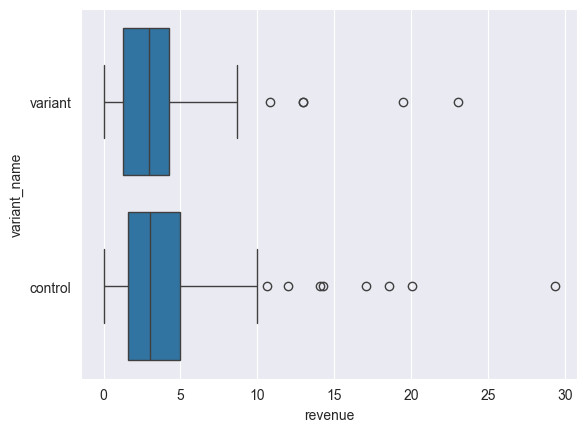

In [14]:
# let's plot the distribution
sns.boxplot(data = revenue_df, x = 'revenue', y = 'variant_name')

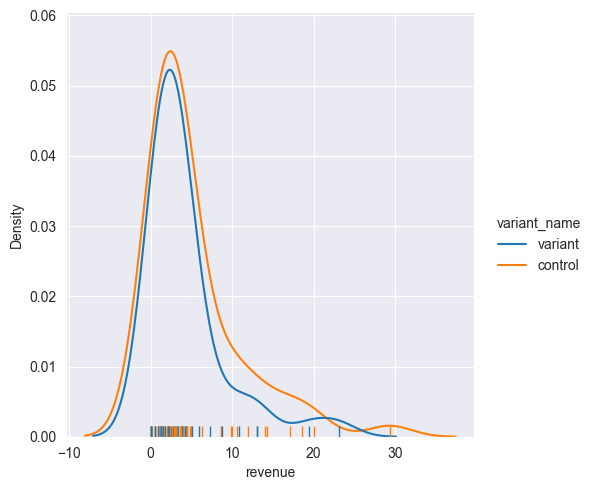

In [15]:
# plot KDE and compare distributions between two groups
sns.displot(data=revenue_df, x="revenue", hue="variant_name", kind="kde", rug=True)

From graph above we can conduct that distributions are quite similar, maybe control group is slightly better. A long tail is visible in the chart.
At this point we end data clearing step.

In [16]:
stat_df = df.groupby(['variant_name'], as_index=False).agg(
    converted_users = ('revenue', lambda x: x[x > 0].count()),
    all_users = ('user_id', lambda x: len(x)),
    revenue =  ('revenue', lambda x: sum(x))
)

stat_df['conversion'] = stat_df['converted_users']/stat_df['all_users']
stat_df['arpu'] = stat_df['revenue']/stat_df['all_users']
stat_df['arppu'] = stat_df['revenue']/stat_df['converted_users']

stat_df

,variant_name,converted_users,all_users,revenue,conversion,arpu,arppu
0,control,53,2389,274.55,0.022185,0.114923,5.180189
1,variant,42,2393,179.32,0.017551,0.074935,4.269524


As we can see overall performance of variant group is worse than control group. The question is following. Is this change statisticaly significant?

## Statistical tests

We will check if the diference in 3 KPIs (Key Performance Indicators) have changed: 
- **Conversion Rate**, 
- **ARPPU** (Average Revenue Per Paying User),
- **ARPU** (Average Revenue Per User).<br>

We can conduct hypothesis as follows:

**H0**: There is no difference between KPI in each group.<br>
**H1**: KPI in groups is different.

In order to check the statistical significance of the difference, the **normality** and **homoscedasticity** of the variance should be checked in the first step.<br>
If the conditions are met, we can use the **Z-test** to confirm the differences between the variants.<br>
Otherwise, we will perform a nonparametric **Mann-Whitney U Test** for which the assumption of normality and homoscedasticity are not required.

In [17]:
# split control and variant group into separate data frames
control_group = df[df['variant_name'] == 'control']
variant_group = df[df['variant_name'] == 'variant']

### Shapiro-Wilk Normality Test

The Shapiro-Wilk test is qualitative as the best test for checking the normal distribution of a random variable. The main advantage of this test is its high power. For α value the probability to reject H0 hypothesis if it is false is greater than in the case of other tests of this type.

The hypotheses are following:<br>
**H0**: The variable is normally distributed.<br>
**H1**: The variable is NOT normally distributed.

If p-value > 0.05: then the null hypothesis cannot be rejected (i.e. the variable MAY BE normally distributed).<br>
If p-value ≤ 0.05: then the null hypothesis can be rejected (i.e. the variable is NOT normally distributed).

In [18]:
# Conversion
control = (control_group['revenue'] > 0).astype(int)
variant = (variant_group['revenue'] > 0).astype(int)

test_stat, pvalue = stats.shapiro(control)
print('Control group Conversion Rate p-value = %.4f.' % (pvalue))
test_stat, pvalue = stats.shapiro(variant)
print('Variant group Conversion Rate p-value = %.4f.\n' % (pvalue))

# ARPU
control = control_group['revenue']
variant = variant_group['revenue']

test_stat, pvalue = stats.shapiro(control)
print('Control group ARPU p-value = %.4f.' % (pvalue))
test_stat, pvalue = stats.shapiro(variant)
print('Variant group ARPU p-value = %.4f.\n' % (pvalue))

# ARPPU
control = control_group[control_group['revenue'] > 0].revenue
variant = variant_group[variant_group['revenue'] > 0].revenue
test_stat, pvalue = stats.shapiro(control)
print('Control group ARPU p-value = %.4f.' % (pvalue))
test_stat, pvalue = stats.shapiro(variant)
print('Variant group ARPU p-value = %.4f.' % (pvalue))




Control group Conversion Rate p-value = 0.0000.
Variant group Conversion Rate p-value = 0.0000.

Control group ARPU p-value = 0.0000.
Variant group ARPU p-value = 0.0000.

Control group ARPU p-value = 0.0000.
Variant group ARPU p-value = 0.0000.


The Shapiro-Wilk test provided that a p-value is lesss than 0.05 for all of KPIs, meaning we reject the Null Hypothesis. **That means the variable doesn't follow normal distribution.**
Therefore, we will use the Mann-Whitney U test.


### Mann-Whitney U Test

The Mann-Whitney U test is used to compare differences between two independent groups when the dependent variable is either ordinal or continuous, but not normally distributed.

The hypotheses are following:<br>
**H0** : There is no significant difference between the two groups (control group = variant group).<br>
**H1** : There is a significant difference between the two groups (control group ≠ variant group).

In [19]:
# Conversion
control = (control_group['revenue'] > 0).astype(int)
variant = (variant_group['revenue'] > 0).astype(int)
test_stat, pvalue = stats.mannwhitneyu(variant, control, alternative = 'greater')
print('Conversion Rate p-value = %.4f.' % (pvalue))

# ARPU
control = control_group['revenue']
variant = variant_group['revenue']
test_stat, pvalue = stats.mannwhitneyu(variant, control, alternative = 'greater')
print('ARPU p-value = %.4f.' % (pvalue))

# ARPPU
control = control_group[control_group['revenue'] > 0].revenue
variant = variant_group[variant_group['revenue'] > 0].revenue
test_stat, pvalue = stats.mannwhitneyu(variant, control, alternative = 'greater')
print('ARPPU p-value = %.4f.' % (pvalue))

Conversion Rate p-value = 0.8745.
ARPU p-value = 0.8760.
ARPPU p-value = 0.7367.


In [22]:
control_group

,user_id,variant_name,revenue
0,2,control,0.0
5,11,control,0.0
6,12,control,0.0
7,13,control,0.0
11,21,control,0.0
...,...,...,...
4774,9980,control,0.0
4777,9989,control,0.0
4779,9992,control,0.0
4780,9993,control,0.0


The Mann-Whitney U test provided a p-value greater than 0.05 for all of KPIs, meaning we can't reject the Null Hypothesis. **That means the change in conversion, ARPU and ARPPU rate is not statistically significant.**


## Bootstrapping

**Bootstrapping** is a statistical procedure that resamples a single dataset to create many simulated samples. This process allows you to calculate standard errors, construct confidence intervals, and perform hypothesis testing. Main difference between bootstrapping and statistical test is that bootstrap can be used to calculate p-values or confidence intervals in any situation - including those that are not appropriate for t-tests or any other known test. For example, with bootstrapping we can compare medians or modes instead of means, and we can't do that with a statistical test.

Bootstrapping steps are following:
1. Choose a number of bootstrap samples to perform (for example 5000).
2. Choose a sample size.
3. For each bootstrap sample:
    1. Draw a sample with replacement with the chosen size.
    2. Calculate the statistic on the sample.
4. Repeat step 3 many times (step 1 number)

In [20]:
print('Control group length:', len(control_group))
print('Variant group length:', len(variant_group))

Control group length: 2389
Variant group length: 2393


Both groups have almost the same amount of observations. Let's start bootstrapping!

In [21]:
iterations = 5000

bootstrap_df = pd.DataFrame()
arpu_p_values = []

for x in tqdm(range(iterations)):  
    iter_df = df.sample(frac = 1, replace=True).groupby(['variant_name'], as_index=False).agg(
        arpu = ('revenue', lambda x: x.sum()/len(x)),
        arppu = ('revenue', lambda x: x[x>0].sum()/len(x[x>0])),
        conversion = ('revenue', lambda x: x[x > 0].count()/len(x))
    )
    
    # control and variant data frames
    control_iter_df = iter_df[iter_df['variant_name'] == 'control'].reset_index()
    variant_iter_df = iter_df[iter_df['variant_name'] == 'variant'].reset_index()
    
    bootstrap_df = pd.concat([bootstrap_df, iter_df])

100%|██████████| 5000/5000 [01:15<00:00, 66.65it/s] 


In [24]:
# bootstrapped data frame
bootstrap_df

,variant_name,arpu,arppu,conversion
0,control,0.097397,5.000426,0.019478
1,variant,0.095044,4.414902,0.021528
0,control,0.145243,5.735902,0.025322
1,variant,0.120055,5.697800,0.021070
0,control,0.113321,4.695000,0.024136
...,...,...,...,...
1,variant,0.061731,4.602813,0.013412
0,control,0.079233,3.826471,0.020706
1,variant,0.069168,4.582857,0.015093
0,control,0.125394,5.701887,0.021992


In [25]:
# transpose data frame
bootstrap_df_melt = pd.melt(bootstrap_df, id_vars = 'variant_name', value_vars = ['conversion', 'arppu', 'arpu'], var_name = 'kpi')
bootstrap_df_melt.head()

,variant_name,kpi,value
0,control,conversion,0.019478
1,variant,conversion,0.021528
2,control,conversion,0.025322
3,variant,conversion,0.021070
4,control,conversion,0.024136


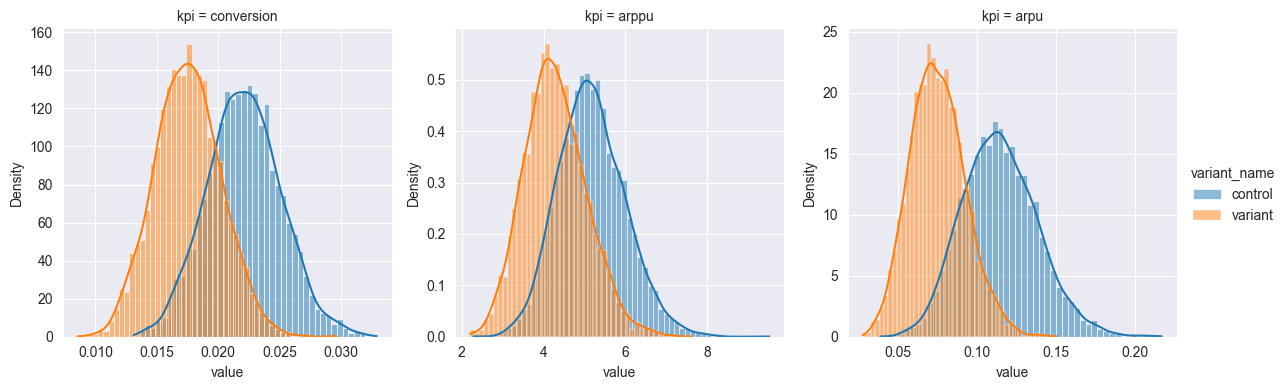

In [26]:
# plot bootstrap distributions
plot = sns.FacetGrid(bootstrap_df_melt, col="kpi", sharex = False, sharey = False, height = 4, hue = 'variant_name')
plot.map_dataframe(sns.histplot, x="value", kde = True, stat = 'density', common_bins = True, fill = True)
plot.add_legend()

All KPIs from variant group seems to be worse than control group. There is an overlap which may suggest that distributions comes from the same population. We will verify this in next steps.

In [27]:
bootstrap_control = bootstrap_df[bootstrap_df['variant_name'] == 'control'].reset_index()
bootstrap_variant = bootstrap_df[bootstrap_df['variant_name'] == 'variant'].reset_index()

In [28]:
# calculate KPIs differences
bootstrap_diffs = pd.DataFrame()

bootstrap_diffs['conversion_diff'] = bootstrap_variant['conversion'] - bootstrap_control['conversion']
bootstrap_diffs['arpu_diff'] = bootstrap_variant['arpu'] - bootstrap_control['arpu']
bootstrap_diffs['arppu_diff'] = bootstrap_variant['arppu'] - bootstrap_control['arppu']

In [29]:
bootstrap_diffs_melt = pd.melt(bootstrap_diffs, value_vars = ['conversion_diff', 'arpu_diff', 'arppu_diff'], var_name = 'kpi')

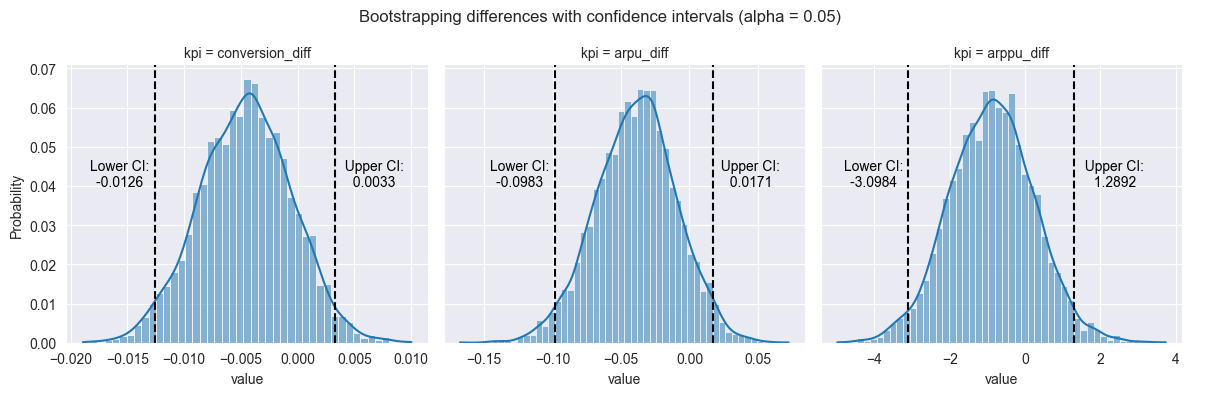

In [30]:
alpha = 0.05

lower_ci = alpha/2
upper_ci = 1 - (alpha/2)

plot = sns.FacetGrid(bootstrap_diffs_melt, col="kpi", sharex = False, sharey = True, height = 4)
plot.map_dataframe(sns.histplot, x="value", kde = True, stat = 'probability', common_bins = True, fill = True)
plot.fig.suptitle('Bootstrapping differences with confidence intervals (alpha = ' + str(alpha) + ')')

# Confidence intervals lines
plot = plot.map(lambda y, **kw: plt.axvline(y.quantile(lower_ci), color='k', linestyle='--'), 'value')
plot = plot.map(lambda y, **kw: plt.axvline(y.quantile(upper_ci), color='k', linestyle='--'), 'value')

# Confidence intervals annotations
plot = plot.map(lambda y, **kw: plt.text(y.quantile(lower_ci),
                                         0.04,
                                         'Lower CI:' + ' ' * 18 + '\n' + str(round(y.quantile(lower_ci), 4)) + ' ' * 18,
                                         color='k',
                                         ha = 'center'),
                'value')
plot = plot.map(lambda y, **kw: plt.text(y.quantile(upper_ci)*1.125,
                                         0.04,
                                         ' ' * 18 + 'Upper CI:\n' + ' ' * 18 + str(round(y.quantile(upper_ci), 4)),
                                         color='k',
                                         ha = 'center'),
                'value')

plot.add_legend()

For KPIs difference between control and variant groups we have designated a 95% confidence interval, which gives an answer to how the measures have changed between variant groups.<br>
Because 0 falls in confidence interval we can't say there is significant difference between variant groups.<br>
From above graphs we can see that there is a high probability that variant group will be worse. But what is the probability?

In [ ]:
conversion_prob = (bootstrap_diffs['conversion_diff'] < 0).mean()
arpu_prob = (bootstrap_diffs['arpu_diff'] < 0).mean()
arppu_prob = (bootstrap_diffs['arppu_diff'] < 0).mean()

print('Probability that Conversion Rate in variant group will be worse than Conversion Rate in control group is', '{:.2%}.'.format(conversion_prob))
print('Probability that ARPU in variant group will be worse than ARPU in control group is', '{:.2%}.'.format(arpu_prob))
print('Probability that ARPPU Rate in variant group will be worse than ARPPU in control group is', '{:.2%}.'.format(arppu_prob))

As we can see there is high probability that variant group will be worse. 

## Conclusions and recommendations

Summary:
- Correct data preparation is necessary to obtain correct results, which is why we filtered out the outlier, removed users with many variants and aggregated the data.
- Both Mann-Whitney U and bootstrapping answered the question about significant difference between groups.
- But there is still high probability (~ 90%) that variant group will be worse than control group.

<br>Recommendations:
- Control variant should be 100% implemented as there is no statistical significance between groups. Another argument is that in variant group there is a higher probability of a worse performance.
- I would also check if there are any errors with assigning the user multiple variant groups on the website.